In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go


In [2]:
amzn_data = yf.download(["AMZN"], start="2020-01-01", end="2025-03-07")

amzn_data['20_MA_AMZN'] = amzn_data['Close']['AMZN'].rolling(window=20).mean()
amzn_data['50_MA_AMZN'] = amzn_data['Close']['AMZN'].rolling(window=50).mean()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


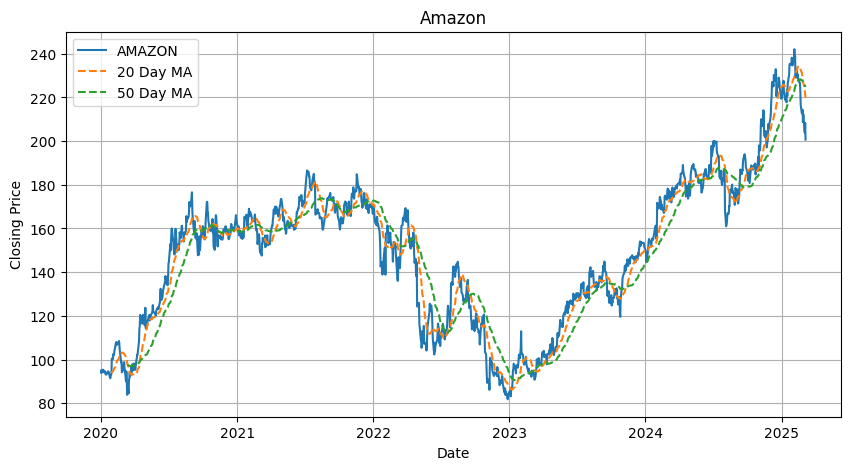

In [3]:
# visualize
plt.figure(figsize=(10, 5))
plt.plot(amzn_data["Close"]['AMZN'], label = 'AMAZON')
plt.plot(amzn_data["20_MA_AMZN"], label = '20 Day MA', linestyle = '--')
plt.plot(amzn_data["50_MA_AMZN"], label = '50 Day MA', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title("Amazon")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
amzn_data

Price,Close,High,Low,Open,Volume,20_MA_AMZN,50_MA_AMZN
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,
Date,,,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,NaN,NaN
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000,NaN,NaN
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000,NaN,NaN
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000,NaN,NaN
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000,NaN,NaN
...,...,...,...,...,...,...,...
2025-02-28,212.279999,212.619995,206.990005,208.649994,51771700,226.440499,226.5972
2025-03-03,205.020004,214.009995,202.550003,213.350006,42948400,224.807500,226.0390


In [5]:
# Create Exponential moving average
# An exponential moving average (EMA) is a widely used technical chart indicator that tracks changes in the price of a financial instrument over a certain period.
#Unlike simple moving average (SMA), EMA puts more emphasis on recent data points like the latest prices.

amzn_data['EMA'] = amzn_data['Close'].ewm(com=0.5).mean()

In [6]:
# Create MACD
# Moving average convergence/divergence (MACD) is a technical indicator to help investors identify entry points for buying or selling
amzn_data['MACD'] = amzn_data['Close'].ewm(span=26).mean() - amzn_data['Open'].ewm(span=12,adjust=False).mean()

In [7]:
# RSI
# It’s a popular momentum oscillator that measures the speed and change of price movements.
rsi_period = 14
delta = amzn_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
amzn_data['RSI'] = rsi

In [8]:
# Technical indicator: Rate of Change (ROC)
amzn_data['ROC'] = amzn_data['Close'].pct_change(periods=7)

In [9]:
# Adaptive average envelop
# Moving averages envelopes are used to: Confirm trend  & Identify overbought and oversold conditions but are static doesn't encounter market votality.
# implementing adaptive envelope percentage to have dynamic envelope percentages that adjust to market conditions.

def calculate_adaptive_envelope_pct(df, window=20):
    """
    Calculate envelope percentage based on market volatility (standard deviation of returns).
    """
    # Calculate daily returns
    returns = df['Close'].pct_change()

    # Calculate volatility (standard deviation of returns) over a rolling window
    volatility = returns.rolling(window=window).std()

    # Normalize the volatility to get a dynamic envelope percentage (e.g., 1-5%)
    envelope_pct = volatility * 2  # Scale the volatility to get an envelope percentage

    # Cap the envelope percentage to a reasonable range
    envelope_pct = envelope_pct.clip(lower=0.01, upper=0.05)  # Cap between 1% and 5%

    return envelope_pct


In [10]:
amzn_data['adaptive_envelope_pct'] = calculate_adaptive_envelope_pct(amzn_data)

In [11]:
# Create Bollinger Bands
amzn_data['20SD'] = amzn_data['Close'].rolling(20).std()
amzn_data['upper_band'] = amzn_data['20_MA_AMZN'] + (amzn_data['20SD'] * 2)
amzn_data['lower_band'] = amzn_data['20_MA_AMZN'] - (amzn_data['20SD'] * 2)


In [30]:
# plot Bollinger Bands

# Create a Plotly figure
fig = go.Figure()

# Add the price chart
fig.add_trace(go.Scatter(x=amzn_data.index, y=amzn_data['Close']['AMZN'], mode='lines', name='Price'))

# Add the Upper Bollinger Band (UB) and shade the area
fig.add_trace(go.Scatter(x=amzn_data.index, y=amzn_data['upper_band'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=amzn_data.index, y=amzn_data['lower_band'], fill='tonexty', mode='lines', name='Lower Bollinger Band', line=dict(color='green')))

# Add the Middle Bollinger Band (MA)

fig.add_trace(go.Scatter(x=amzn_data.index, y=amzn_data['20_MA_AMZN'], mode='lines', name='Middle Bollinger Band', line=dict(color='blue')))

# Customize the chart layout
fig.update_layout(title='Amazon Stock Price with Bollinger Bands',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the chart
fig.show()

In [24]:
# check for feature importance using Random Forest
X = amzn_data[['Volume', 'High', 'Low', 'Open', 'EMA','20_MA_AMZN', '50_MA_AMZN', 'ROC', 'MACD', 'RSI', 'adaptive_envelope_pct', '20SD','upper_band', 'lower_band']]
Y = amzn_data['Close']['AMZN']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [26]:
# Train Random Forest
model = RandomForestRegressor()
model.fit(X_train, Y_train)

# Get feature importance
importance = model.feature_importances_


In [28]:
# Get feature importance
importance = model.feature_importances_
for feature, score in zip(X.columns, importance):
    print(f"{feature}: {score:.2f}")

('Volume', 'AMZN'): 0.00
('High', 'AMZN'): 0.09
('Low', 'AMZN'): 0.09
('Open', 'AMZN'): 0.00
('EMA', ''): 0.82
('20_MA_AMZN', ''): 0.00
('50_MA_AMZN', ''): 0.00
('ROC', ''): 0.00
('MACD', ''): 0.00
('RSI', ''): 0.00
('adaptive_envelope_pct', ''): 0.00
('20SD', ''): 0.00
('upper_band', ''): 0.00
('lower_band', ''): 0.00
